In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from collections import defaultdict
from scipy.sparse import dok_matrix, csr_matrix
from sklearn.preprocessing import normalize
import networkx as nx
import itertools
from itertools import islice
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
import scipy as sp
import math
import csv
from collections import OrderedDict
import sys
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import LinearSegmentedColormap


mpl.rcParams['figure.dpi'] = 100
plt.rcParams.update({'font.size': 7,'axes.linewidth':0.5,
                     'xtick.major.size':2,'xtick.major.width':0.5,
                    'ytick.major.size':2,'ytick.major.width':0.5})
plt.rcParams.update({'mathtext.default':  'regular' })


colorMA90, colorSI06 = "#E8735C", "#72C2A6"


#### antibody choice ####
antibody = "CH65"
antigens = ["MA90", "SI06"]
L = 16
sequences_int = range(2**L)


#### selection model choice ####
#model = 'strong'
model = 'moderate'
#model = 'weak'
################################

if model == 'moderate':
    N = 1000
    gamma = 1.0
elif model == 'weak':
    N = 20
    gamma = 0.5

Nbootstrap = 10


# define some functions
def mutation(s, ii, L):
    """ Return the sequence (in int format) with base s,
        with a somatic mutation at pos ii """
    return s | 2**(L-1-ii)

def nb_mutation(s):
    """ Number of mutations in variant s """
    return bin(s).count("1")

def reachable(s, L):
    return [(s | 2**ii) for ii in range(L) if (s | 2**ii) > s]

def k_shortest_paths(G, source, target, k, weight=None):
    return list(
        islice(nx.shortest_simple_paths(G, source, target, weight=weight), k)
    )
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap


#can add a constraint to pass thru intermediate here
is_intermediate = True
INTERMEDIATE = int('0000001010100000', 2)
nb_mut_int = nb_mutation(INTERMEDIATE)
force_intermediate = dok_matrix((2**L, 2**L), dtype=np.float64)
for mut in range(L):
    t = mutation(INTERMEDIATE, mut, L)
    force_intermediate[INTERMEDIATE, t] = 1
    

# define data and image folder
data = ""
img = ""
##############################

## Load data

In [38]:
# read dataframe
df = pd.read_csv(f"../../Kd_Inference/results_CH65/Kd_processed/20220603_CH65_QCfilt_REPfilt.csv", dtype={"geno":"str"})
df = df.rename(columns={"MA90_mean": "MA90_log10Kd", "SI06_mean": "SI06_log10Kd",
                        "MA90_sem": "MA90_stelog10Kd", "SI06_sem": "SI06_stelog10Kd"})

# convert genotypes to integers and sort accordingly    
df["variant_int"] = df.geno.apply(lambda x: int(x, 2))
df = df.set_index("variant_int").reindex(range(0, 2**L)).reset_index()

for ii in range(L):
    df[f"mutation_{ii+1}"] = df.geno.str[ii] == '1'
      
# get average Kd for mixed scenarios    
df['mixed_log10Kd'] = df[[f"{a}_log10Kd" for a in antigens]].mean(axis=1)
df

,variant_int,geno,repa_x,repb_x,MA90_log10Kd,MA90_stelog10Kd,repa_y,repb_y,SI06_log10Kd,SI06_stelog10Kd,...,mutation_8,mutation_9,mutation_10,mutation_11,mutation_12,mutation_13,mutation_14,mutation_15,mutation_16,mixed_log10Kd
0,0,0000000000000000,8.612721,8.472320,8.542521,0.070200,6.000000,6.000000,6.000000,0.000000,...,False,False,False,False,False,False,False,False,False,7.271260
1,1,0000000000000001,8.631980,8.516378,8.574179,0.057801,6.000000,6.000000,6.000000,0.000000,...,False,False,False,False,False,False,False,False,True,7.287090
2,2,0000000000000010,8.340245,8.290790,8.315518,0.024727,6.000000,6.000000,6.000000,0.000000,...,False,False,False,False,False,False,False,True,False,7.157759
3,3,0000000000000011,8.511183,8.436571,8.473877,0.037306,6.000000,6.000000,6.000000,0.000000,...,False,False,False,False,False,False,False,True,True,7.236939
4,4,0000000000000100,8.552056,8.523392,8.537724,0.014332,6.000000,6.000000,6.000000,0.000000,...,False,False,False,False,False,False,True,False,False,7.268862
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65531,65531,1111111111111011,10.103725,10.109438,10.106582,0.002856,9.173063,9.109244,9.141153,0.031909,...,True,True,True,True,True,True,False,True,True,9.623867
65532,65532,1111111111111100,10.092798,10.039002,10.065900,0.026898,8.775637,8.804350,8.789993,0.014357,...,True,True,True,True,True,True,True,False,False,9.427947
65533,65533,1111111111111101,10.114984,10.152478,10.133731,0.018747,8.985615,9.035222,9.010419,0.024804,...,True,True,True,True,True,True,True,False,True,9.572075
65534,65534,1111111111111110,9.969711,9.965975,9.967843,0.001868,8.578370,8.672535,8.625453,0.047082,...,True,True,True,True,True,True,True,True,False,9.296648


## Define selection model

In [39]:
def fixation_probability_moderate(fitness_s,fitness_t,Npop,gamma):
    if np.isnan(fitness_s) or np.isnan(fitness_t):
        pval = 0.0
    else:
        delta = fitness_t - fitness_s
        if delta == 0.0:
            pval = 1.0/Npop
        else:
            # avoid overflow errors
            if gamma*delta > 100:
                pval = 1
            elif Npop*gamma*delta < -100:
                pval = 0
            elif Npop*gamma*delta > 100:
                pval = (1 - np.exp(-gamma*delta))
            else:
                pval = ((1 - np.exp(-gamma*delta))/(1 - np.exp(-Npop*gamma*delta)))
    return pval

def log_fixation_probability_moderate(fitness_s,fitness_t,Npop,gamma):
    if np.isnan(fitness_s) or np.isnan(fitness_t):
        pval = 0.0
    else:
        delta = fitness_t - fitness_s
        if delta == 0.0:
            pval = np.log(1.0/Npop)
        else:
            # avoid overflow errors
            if gamma*delta > 100:
                pval = np.log(1)
            elif Npop*gamma*delta < -100:
                pval = -gamma*delta + Npop*gamma*delta
            elif Npop*gamma*delta > 100:
                pval = np.log((1 - np.exp(-gamma*delta)))
            else:
                pval = np.log(((1 - np.exp(-gamma*delta))/(1 - np.exp(-Npop*gamma*delta))))
    return pval
    
    
def fixation_probability_binary(s,fitness_s,fitness_t):
    if np.isnan(fitness_s) or np.isnan(fitness_t):
        pval = 0.0
    elif (fitness_t-fitness_s) > 0:
        pval = 1.0
    else:
        pval = 0.0
    return pval


## Calculate transition probabilities

In [40]:
Nbootstrap = 10

# Create the transition matrix between variant, depending on context
pmut = {}
for nb in tqdm(range(Nbootstrap)):
    for ag in antigens + ["mixed"]:
        pmut[ag, nb] = dok_matrix((2**L, 2**L), dtype=np.float64)
        if ag != "mixed":
            fitnesses = np.random.normal(
                        (df[f"{ag}_log10Kd"]).values.astype('float32'),
                        (df[f"{ag}_stelog10Kd"]).values.astype('float32'))
        else:
            fitnesses = sum([np.random.normal(
                        (df[f"{aa}_log10Kd"]).values.astype('float32'),
                        (df[f"{aa}_stelog10Kd"]).values.astype('float32')) for aa in antigens])/len(antigens)
        
        for s in sequences_int:
            tot = 0
            for t in reachable(s, L):
                if is_intermediate and t != INTERMEDIATE and nb_mutation(t) == nb_mutation(INTERMEDIATE):
                    pmut[ag, nb][s, t] = 0
                else:
                    if model == 'strong':
                        pmut[ag, nb][s, t] = fixation_probability_binary(s,fitnesses[s],fitnesses[t])
                    else:  
                        pmut[ag, nb][s, t] = fixation_probability_moderate(fitnesses[s],fitnesses[t],N,gamma)

        ### change format for something that can deal with multiplications
        pmut[ag, nb].tocsr()

  0%|          | 0/10 [00:00<?, ?it/s]

In [41]:
### compute for every context
all_contexts = set()
for order in itertools.permutations(antigens):
    for a in itertools.combinations_with_replacement(order, L):
        all_contexts.add(a)
all_contexts.add(tuple(["mixed"]*L))

proba = defaultdict(list)
for context in tqdm(all_contexts):
    for nb in range(Nbootstrap):
        P = pmut[context[0], nb][0, :] # start vector
        for c in context[1:]:
            P = P@pmut[c, nb]
        proba[context] += [P[0, 2**L - 1]]

# write data to file
with open(f'likelihoods_'+antibody+'_'+model+'.csv','w') as writefile:
    proba_writer = csv.writer(writefile)
    for key in proba.keys():
        list_to_write = [x for x in key] + [x for x in proba[key]]
        proba_writer.writerow(list_to_write)
    writefile.close()


  0%|          | 0/33 [00:00<?, ?it/s]

In [42]:
# draw random contexts
num_random_contexts = 1000
random_contexts = []
for i in range(num_random_contexts):
    random_contexts.append(np.random.choice(antigens,size=L))
        
proba_random = np.zeros((num_random_contexts,Nbootstrap))
for i in tqdm(range(num_random_contexts)):
    context = random_contexts[i]
    for nb in range(Nbootstrap):
        P = pmut[context[0], nb][0, :] # start vector
        for c in context[1:]:
            P = P@pmut[c, nb]
        proba_random[i,nb] += [P[0, 2**L - 1]]
        
proba_random_mean = np.mean(np.mean(proba_random,axis=1),axis=0)
proba_random_std = np.std(np.std(proba_random,axis=1))
print(proba_random_mean,proba_random_std)

# write data to file
with open(f'likelihoods_'+antibody+'_'+model+'_random.csv','w') as writefile:
    proba_writer = csv.writer(writefile)
    for i in range(len(proba_random)):
        list_to_write = [x for x in random_contexts[i]] + [x for x in proba_random[i]]
        proba_writer.writerow(list_to_write)
    writefile.close()



  0%|          | 0/1000 [00:00<?, ?it/s]

1.6731512081317794e-08 6.512010037740339e-08


## Recalculate normalized probabilities for selected contexts (no bootstrapping)

In [43]:
proba_from_file = defaultdict(list)
with open(f'likelihoods_'+antibody+'_'+model+'.csv','r') as readfile:
    proba_reader = csv.reader(readfile)
    for row in proba_reader:
        key = tuple(row[:L])
        value = [float(x) for x in row[L:]]
        proba_from_file[key] = value
    readfile.close()

num_random_contexts = 1000
proba_random_from_file = np.zeros((num_random_contexts,Nbootstrap))
contexts_random_from_file = []
with open(f'likelihoods_'+antibody+'_'+model+'_random.csv','r') as readfile:
    proba_reader = csv.reader(readfile)
    i = 0
    for row in proba_reader:
        key = tuple(row[:L])
        contexts_random_from_file.append(key)
        value = [float(x) for x in row[L:]]   
        proba_random_from_file[i] = value
        i += 1
    readfile.close()

In [44]:
print(math.factorial(L))
print(np.mean(proba_from_file[tuple(["MA90"]*L)])/math.factorial(L))
print(np.std(proba_from_file[tuple(["MA90"]*L)],ddof=1)/math.factorial(L))

20922789888000
4.6933973273809774e-27
4.208404741542963e-27


In [45]:
import pickle
# Calculate normalized transition matrices 
pmut_unnormed = {}
pmut_normed = {}
for ag in antigens+['mixed']:
    pmut_unnormed[ag] = dok_matrix((2**L, 2**L), dtype=np.float64)
    fitnesses = df[f"{ag}_log10Kd"].values.astype('float32')
    
    for s in tqdm(sequences_int):
        for t in reachable(s, L):
            if is_intermediate and t != INTERMEDIATE and nb_mutation(t) == nb_mutation(INTERMEDIATE):
                pmut_unnormed[ag][s, t] = 0
            else:
                if model == 'strong':
                    pmut_unnormed[ag][s, t] = fixation_probability_binary(s,fitnesses[s],fitnesses[t])
                else:  
                    pmut_unnormed[ag][s, t] = fixation_probability_moderate(fitnesses[s],fitnesses[t],N,gamma)

    pmut_normed[ag] = pmut_unnormed[ag].copy()
    spmut = pmut_unnormed[ag].sum(axis=1)
    for s in tqdm(sequences_int):
        # if we are at a local maximum, and N/γ are large enough, the fixation probability
        # can be too low to be measured by the fixation_probability_moderate function for all
        # the reachable sites.
        # this is a problem because of the normalisation
        # the solution is to compute it explicitely in these specific case
        if spmut[s] == 0 and s != 2**L - 1:
            lps = {}
            for t in reachable(s, L):
                if is_intermediate and t != INTERMEDIATE and nb_mutation(t) == nb_mutation(INTERMEDIATE):
                    lps[t] = -np.inf
                else:
                    lps[t] = log_fixation_probability_moderate(fitnesses[s],fitnesses[t],N,gamma)
            mp = max(lps.values()) # remove the max to get into reasonnable value before exponentiation
            for t in lps:
                if (lps[t] - mp) < -100:
                    pmut_normed[ag][s, t] = 0
                else:
                    if lps[t] <= -np.inf:
                        pmut_normed[ag][s, t] = 0
                    else:
                        pmut_normed[ag][s, t] = np.exp(lps[t] - mp)
                    

    ### normalize the sparse matrix
    pmut_normed[ag].tocsr()
    pmut_normed[ag] = normalize(pmut_normed[ag], norm='l1', axis=1)
    ### change format for something that can deal with multiplications
    pmut_unnormed[ag].tocsr()
with open(f"pmut_normed.pkl", 'wb') as f:
    pickle.dump(pmut_normed, f)
with open(f"pmut_unnormed.pkl", 'wb') as f:
    pickle.dump(pmut_unnormed, f)

  0%|          | 0/65536 [00:00<?, ?it/s]

  0%|          | 0/65536 [00:00<?, ?it/s]

  0%|          | 0/65536 [00:00<?, ?it/s]

  0%|          | 0/65536 [00:00<?, ?it/s]

  0%|          | 0/65536 [00:00<?, ?it/s]

  0%|          | 0/65536 [00:00<?, ?it/s]

617
('SI06', 'SI06', 'MA90', 'SI06', 'SI06', 'MA90', 'SI06', 'SI06', 'SI06', 'SI06', 'MA90', 'MA90', 'SI06', 'SI06', 'SI06', 'SI06') -25.187261305715577


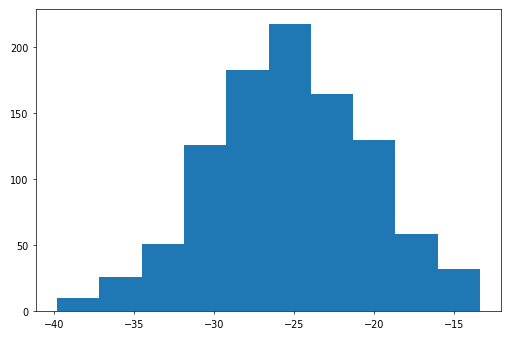

-25.52286259860282
Optimal: ('MA90', 'MA90', 'MA90', 'MA90', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06', 'SI06')


In [46]:
#find the best and median random contexts
random_means = np.mean(proba_random_from_file,axis=1)
random_means_sorted = sorted(range(len(random_means)),key = lambda x: random_means[x])
median_random_index = random_means_sorted[int(len(random_means)/2)+2] 
print(median_random_index) #np.log(proba_random[median_random_index]))
median_random = contexts_random_from_file[median_random_index]
print(median_random,np.log(random_means[median_random_index]))

plt.hist(np.log(np.mean(proba_random_from_file,axis=1)))
plt.show()
print(np.mean(np.log(proba_random_from_file)))

# sort other scenarios by likelihood
scenarios_sorted = [k for k, v in sorted(proba_from_file.items(), key=lambda item: -np.log(np.mean([a for a in item[1] if a > 1e-80]))) if not all([l == k[0] for l in k])]

if antibody == 'CH65':
    top_set = scenarios_sorted[:18]
    print('Optimal:',top_set[0])  

In [47]:
if antibody == "CH65":
    antigen_contexts = { "optimal": ["MA90"]*4 + ["SI06"]*12,
                            "MA90alone": ["MA90"]*16,  
                         "SI06alone": ["SI06"]*16,
                         "mixed": ["mixed"]*16,
                           "random_median": median_random}

## Compute mutation order

In [48]:

for ac in tqdm(antigen_contexts):
    ## precompute the transition probability matrix to every power
    ## pmut_power[s, e] is the product of all normed matrix between s and e (excluded)
    pmut_power = {}
    for s in range(L+1):
        for e in range(s, L+1):
            pmut_power[s, e] = pmut_normed[antigen_contexts[ac][0]]**0 #identity matrix
            for j in range(s, e):
                pmut_power[s, e] = pmut_power[s, e]@pmut_normed[antigen_contexts[ac][j]]
                
    ## compute the matrix that force the mutation to be mut
    force_mut = {}
    for mut in range(L):
        for i in range(L):
            force_mut[(i,mut)] = dok_matrix((2**L, 2**L), dtype=np.float64)
        
        for s in sequences_int[:-1]:
            nb_mut = nb_mutation(s)
            t = mutation(s, mut, L)
            force_mut[(nb_mut,mut)][s, t] = pmut_normed[antigen_contexts[ac][nb_mut]][s, t]
        
    ## compute probabilities
    proba = np.zeros((L, L))
    for mut in range(L):
        for t in range(L):
            proba[mut, t] = (pmut_power[0, t] @ force_mut[(t,mut)] @ pmut_power[t+1, L])[0, 2**L - 1]

    ## print results to file
    if antibody == 'CH65':
        proba_df = pd.DataFrame(proba,columns=
                        ["Order 1","Order 2","Order 3","Order 4","Order 5","Order 6",
                         "Order 7","Order 8","Order 9","Order 10","Order 11","Order 12",
                        "Order 13","Order 14","Order 15","Order 16"])
        proba_df['Mutation'] = ["Mut 1","Mut 2","Mut 3","Mut 4","Mut 5","Mut 6",
                       "Mut 7","Mut 8","Mut 9","Mut 10","Mut 11",
                       "Mut 12","Mut 13","Mut 14","Mut 15","Mut 16"] 
        proba_df.to_csv(f"CH65_probability_"+str(ac)+"_"+model+".csv",index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

## Output best paths

In [49]:
# make directed weighted graph

# store fitnesses as dict
fitnesses = {}
for a in antigens+['mixed']:
    fitnesses[a] = (df.set_index("variant_int")[f"{a}_log10Kd"]).to_dict()

df["nb_mutation"] = df.variant_int.apply(nb_mutation)

# choose number of best paths to store
num_best_paths = 25
best_paths = {}

for ac in tqdm(antigen_contexts):
    # (re) create the graph with networkx (as a directed graph)
    G = nx.DiGraph()
    G.add_nodes_from(sequences_int)
    G.add_weighted_edges_from([(s, t,  ## source, target
                                -np.log(1e-100 + pmut_normed[antigen_contexts[ac][nb_mutation(s)]][s, t])  # weight
                               ) 
                      for s in sequences_int
                      for t in reachable(s, L)])
    
    if is_intermediate:
        for s in sequences_int:
            if s != INTERMEDIATE and nb_mutation(s) == nb_mut_int:
               G.remove_node(s)
    
    # compute the k shortest paths, for which ∑ -log(p) is smallest => max likelihood
    best_paths[ac] = np.empty((num_best_paths,L+1),dtype=int)
    i = 0
    for path in k_shortest_paths(G, 0, 2**L-1,num_best_paths,weight='weight'):
        best_paths[ac][i] = path
        i += 1
        
with open(f"best_paths.pkl", 'wb') as f:
    pickle.dump(best_paths, f)

  0%|          | 0/5 [00:00<?, ?it/s]

## Compute uphill paths

In [50]:
## number of only increasing path

## create pmut matrix 
Nbootstrap = 10
# Create the transition matrix between variant, depending on context
pmut = {}
for nb in tqdm(range(Nbootstrap)):
    for ag in antigens + ["mixed"]:
        pmut[ag, nb] = dok_matrix((2**L, 2**L), dtype=np.float64)
        if ag != "mixed":
            fitnesses = np.random.normal(
                        (df[f"{ag}_log10Kd"]).values.astype('float32'),
                        (df[f"{ag}_stelog10Kd"]).values.astype('float32'))
        else:
            fitnesses = sum([np.random.normal(
                        (df[f"{aa}_log10Kd"]).values.astype('float32'),
                        (df[f"{aa}_stelog10Kd"]).values.astype('float32')) for aa in antigens])/len(antigens)
        
        for s in sequences_int:
            tot = 0
            for t in reachable(s, L):
                if is_intermediate and t != INTERMEDIATE and nb_mutation(t) == nb_mutation(INTERMEDIATE):
                    pmut[ag, nb][s, t] = 0
                else:
                    pmut[ag, nb][s, t] = fixation_probability_binary(s,fitnesses[s],fitnesses[t])
        ### change format for something that can deal with multiplications
        pmut[ag, nb].tocsr()
        
path_increasing = {}
for ac in antigen_contexts:
    path_increasing[ac] = []
    for nb in tqdm(range(Nbootstrap)):
        mat = pmut[antigen_contexts[ac][0], 0]**0
        for ag in antigen_contexts[ac]:
            mat = mat@pmut[ag, nb]
        path_increasing[ac] += [mat[0, 2**L-1]]
        
for ac in path_increasing:
    print(f"{ac}: {np.mean(path_increasing[ac]):.2} ± {np.std(path_increasing[ac]):.2}")  

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

optimal: 1.3e+07 ± 5.8e+06
MA90alone: 3.2e+06 ± 1.4e+06
SI06alone: 0.0 ± 0.0
mixed: 2.2e+07 ± 8.4e+06
random_median: 0.0 ± 0.0
